In [13]:
# Load the dataset
import pandas as pd
url = 'https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/energy/SF_hospital_load.csv'
df = pd.read_csv(url)
print(df.head())

                    ds           y
0  2015-01-01 01:00:00  778.007969
1  2015-01-01 02:00:00  776.241750
2  2015-01-01 03:00:00  779.357338
3  2015-01-01 04:00:00  778.737196
4  2015-01-01 05:00:00  787.835835


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      8760 non-null   object 
 1   y       8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB
None


In [15]:
df['ds'] = pd.to_datetime(df['ds'])

In [16]:
#df.rename(columns={'ds': 'datetime', 'y': 'consumption'}, inplace=True)

In [17]:
print(df.describe())

                        ds            y
count                 8760  8760.000000
mean   2015-07-02 12:30:00  1012.454652
min    2015-01-01 01:00:00   715.644051
25%    2015-04-02 06:45:00   820.487963
50%    2015-07-02 12:30:00   931.869578
75%    2015-10-01 18:15:00  1242.089126
max    2016-01-01 00:00:00  1388.981796
std                    NaN   198.329809


In [18]:
!pip install prophet

In [19]:
# Train-validation split (80%,20%) bacause we have relatively small dataset
split_index = int(0.8 * len(df))
train_df = df.iloc[:split_index]
val_df = df.iloc[split_index:]

print(f"Training size: {len(train_df)}, Validation size: {len(val_df)}")


Training size: 7008, Validation size: 1752


In [21]:
#create model
from prophet import Prophet
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplilp79eh/ef_fx0mw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplilp79eh/yf0dc8v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69868', 'data', 'file=/tmp/tmplilp79eh/ef_fx0mw.json', 'init=/tmp/tmplilp79eh/yf0dc8v5.json', 'output', 'file=/tmp/tmplilp79eh/prophet_model_m5onx97/prophet_model-20240928120425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
val_df.head()

,ds,y
7008,2015-10-20 01:00:00,801.461417
7009,2015-10-20 02:00:00,809.616991
7010,2015-10-20 03:00:00,816.708010
7011,2015-10-20 04:00:00,901.156937
7012,2015-10-20 05:00:00,901.078524


In [34]:
# Make predictions for next 1752 h = 2.4 month
future = model.make_future_dataframe(periods=len(val_df), freq='H')  # 'H' for hourly data
forecast = model.predict(future)
forecast_with_actuals = pd.merge(forecast[-len(val_df):], val_df[['ds', 'y']], on='ds', how='left')
print(forecast_with_actuals[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head())


                   ds           y        yhat  yhat_lower   yhat_upper
0 2015-10-20 01:00:00  801.461417  841.819530  741.593932   944.384952
1 2015-10-20 02:00:00  809.616991  837.094015  733.213723   935.822861
2 2015-10-20 03:00:00  816.708010  843.185054  735.529641   946.387835
3 2015-10-20 04:00:00  901.156937  874.947817  769.238366   989.172619
4 2015-10-20 05:00:00  901.078524  940.489904  830.525611  1044.996405


In [38]:
#evaluate model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(forecast_with_actuals['y'], forecast_with_actuals['yhat'])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 77.99155352844694


ratio (MAE/mean consumption) = 77.99155352844694 / 1012.454652 =**7.7%**

-> not bad nevertheless not great for low values of energy consumption like min (715.644051)

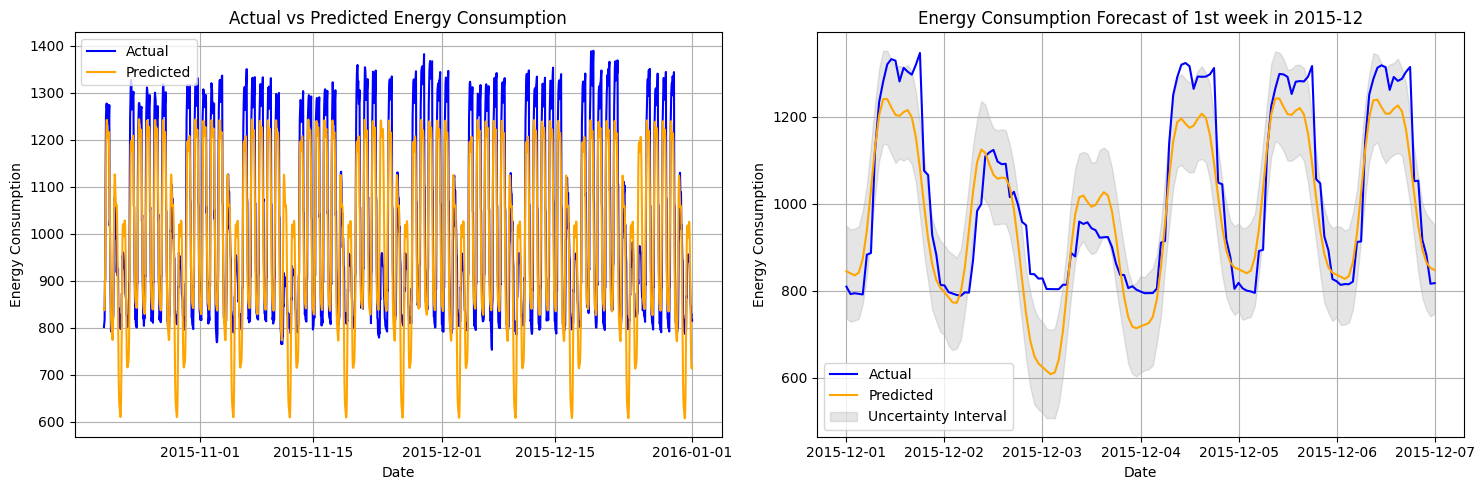

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# Plot y vs yhat
axs[0].plot(val_df['ds'], forecast_with_actuals['y'], label='Actual', color='blue')
axs[0].plot(val_df['ds'], forecast_with_actuals['yhat'], label='Predicted', color='orange')
axs[0].set_title('Actual vs Predicted Energy Consumption')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Energy Consumption')
axs[0].legend()
axs[0].grid()

#plot first week of 2015-12 prdictions for better visualization
month_to_plot = '2015-12'
start_date = f'{month_to_plot}-01'
end_date = f'{month_to_plot}-07'

# first week of 2015-12 forecast
forecast_month = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
val_month = val_df[(val_df['ds'] >= start_date) & (val_df['ds'] <= end_date)]

axs[1].plot(val_month['ds'], val_month['y'], label='Actual', color='blue')
axs[1].plot(forecast_month['ds'], forecast_month['yhat'], label='Predicted', color='orange')
axs[1].fill_between(forecast_month['ds'], forecast_month['yhat_lower'], forecast_month['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')
axs[1].set_title(f'Energy Consumption Forecast of 1st week in {month_to_plot}')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Energy Consumption')
axs[1].legend()
axs[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

In [50]:
 # Save model
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))
